In [2]:
from pyspark.sql import SparkSession
import os
import findspark

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

findspark.init()

In [ ]:
spark = SparkSession.builder.appName("lets do some querying").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [ ]:
df = spark.read.parquet(f"/parkingviolations/raw_all.parquet").cache()

In [5]:
df.printSchema()

root
 |-- violation_code: integer (nullable = true)
 |-- summons_number: integer (nullable = true)
 |-- plate_id: string (nullable = true)
 |-- registration_state: string (nullable = true)
 |-- plate_type: string (nullable = true)
 |-- issue_date: date (nullable = true)
 |-- vehicle_body_type: string (nullable = true)
 |-- vehicle_make: string (nullable = true)
 |-- issuing_agency: string (nullable = true)
 |-- street_code1: integer (nullable = true)
 |-- street_code2: integer (nullable = true)
 |-- street_code3: integer (nullable = true)
 |-- vehicle_expiration_date: integer (nullable = true)
 |-- violation_location: string (nullable = true)
 |-- violation_precinct: integer (nullable = true)
 |-- issuer_precinct: integer (nullable = true)
 |-- issuer_code: integer (nullable = true)
 |-- issuer_command: string (nullable = true)
 |-- issuer_squad: string (nullable = true)
 |-- violation_time: string (nullable = true)
 |-- time_first_observed: string (nullable = true)
 |-- violation_coun

## Question 1: What's the most amount that was paid in violations and by which Plate ID?

In [6]:
filtered_df = df.filter((df.plate_id != "BLANKPLATE") & (df.plate_id != "N/A"))

violations_count = filtered_df.groupBy("plate_id", "vehicle_make").count()

top_violated_plates = violations_count.orderBy("count", ascending=False).limit(10)

top_violated_plates.show()

+--------+------------+-----+
|plate_id|vehicle_make|count|
+--------+------------+-----+
| 12863KA|        FORD| 7344|
| 47603MD|       PETER| 7320|
| 2028685|       VOLVO| 6926|
| 96091MA|       FRUEH| 6473|
| 56253MG|       FRUEH| 6470|
| 47832MD|       PETER| 6439|
| 52969MD|       FRUEH| 6268|
| 83460MH|       FRUEH| 5988|
| 12125MJ|       FRUEH| 5920|
| 47601MD|       PETER| 5809|
+--------+------------+-----+



In [8]:
from pyspark.sql.functions import desc
filtered_df = df.filter((df.plate_id != "BLANKPLATE") & (df.plate_id != "N/A"))

result_df = filtered_df.groupBy("plate_id") \
             .agg(sum("fine_amount").alias("total_fine_amount")) \
             .orderBy("total_fine_amount") \
             .orderBy(desc("total_fine_amount"))


result_df.show()

+--------+-----------------+
|plate_id|total_fine_amount|
+--------+-----------------+
| 47603MD|         846407.5|
| 12863KA|         793577.5|
| 47832MD|         726047.5|
| 56253MG|         720915.0|
| 30954JX|         689490.0|
| 52969MD|         678772.5|
| 17744MD|         677172.5|
| 47601MD|         670632.5|
| 12125MJ|         667880.0|
| 83460MH|         665475.0|
| 16223TC|         664930.0|
| 47602MD|         664180.0|
| 96091MA|         654795.0|
| 17741MD|         649907.5|
| 68094JZ|         642710.0|
| 16213TC|         637410.0|
| 63394JM|         630322.5|
| 85829JB|         621282.5|
| 85994MD|         620710.0|
| 12821KA|         617697.5|
+--------+-----------------+
only showing top 20 rows



The query returns the license plate ids and the amount of fines collected on them over 10 years. The plate id 47603MD has the highest value of fines collected in the last 10 years with a value of 846'407.5 dollars. This seems to be too high at first. But considering some facts it could be the case. First, we have to divide the amount of fines over 10 years, which results in an annual average of 84,641 dollars. According to https://www.nyc.gov/html/dot/downloads/pdf/nyc_greendividend_april2010.pdf New Yorkers own 2 million cars. So the chances that there are some car owners who do not follow any parking rules, especially in a city with so many rich people is possible. Additionally, you have to consider that it's not just this one outlier, there are many other license plates that are close to this number. Because we didn't get the total fine amount from one data point, but by summing up all the amounts registered on this license plate, it is more possible that this is not a case of false data.

## Question 2: At what hour of the day is it most likely to get a ticket?

Most likely hour to get a ticket is: 9
The number of tickets issued during that hour: 13956669


+----------+--------+---------------------+
|issue_hour|count   |likeliness_percentage|
+----------+--------+---------------------+
|9         |13956669|9.73885129251759     |
|11        |13838039|9.656072233357314    |
|8         |13054246|9.10914778662033     |
|13        |13043221|9.101454630359333    |
|10        |11518288|8.03736865697609     |
|14        |11411279|7.962698638079675    |
|15        |8722397 |6.08641842099297     |
|7         |7990401 |5.575637503947671    |
|16        |7428136 |5.183293512556357    |
|17        |5750077 |4.0123574488673235   |
|6         |4079367 |2.8465494582270026   |
|18        |3806819 |2.6563676575356565   |
|1         |3458389 |2.4132360080101214   |
|5         |3376263 |2.355929146233196    |
|2         |3034098 |2.11716916328137     |
|0         |2871407 |2.0036446929632032   |
|3         |2766792 |1.9306451879977469   |
|20        |2616429 |1.825723096852874    |
|4         |2525885 |1.7625422224314977   |
|21        |2484729 |1.733823896

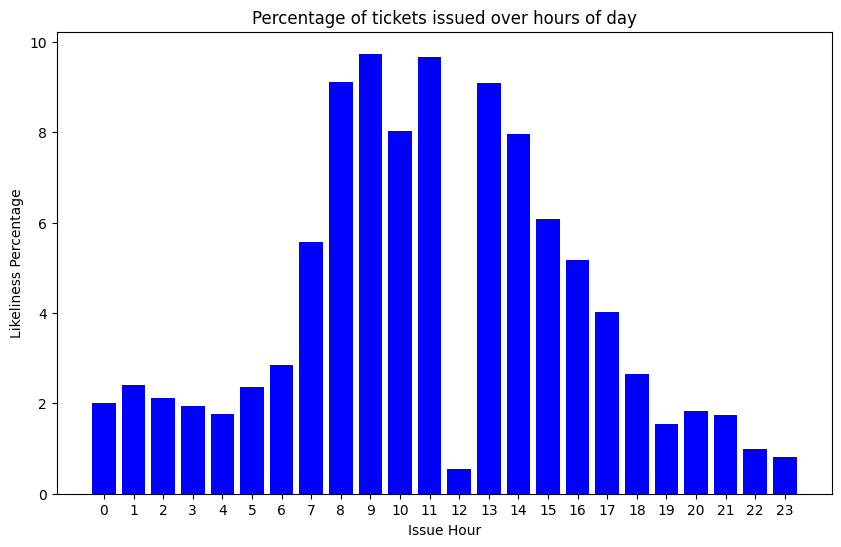

In [9]:
from pyspark.sql.functions import hour, col
import matplotlib.pyplot as plt
# hour extraction
df_with_hour = df.withColumn("issue_hour", hour(col("issue_datetime")))

# tickets per hour
hourly_ticket_counts = df_with_hour.groupBy("issue_hour").count()

# Hour with the highest amounts of tickets issued
most_likely_hour = hourly_ticket_counts.orderBy(col("count").desc()).first()
most_likely_hour_of_day = most_likely_hour["issue_hour"]
ticket_count_at_peak_hour = most_likely_hour["count"]



# Calculate the total number of tickets for percentages
total_tickets = df_with_hour.count()

# Calculate the percentage likelihood for each hour
hourly_ticket_counts = hourly_ticket_counts.withColumn(
    "likeliness_percentage",
    (col("count") / total_tickets) * 100
)

# Show results
print(f"Most likely hour to get a ticket is: {most_likely_hour_of_day}")
print(f"The number of tickets issued during that hour: {ticket_count_at_peak_hour}")
hourly_ticket_counts.orderBy(hourly_ticket_counts.likeliness_percentage.desc()) \
.show(24, truncate=False)



# Convert to pandas for plotting
pandas_df = hourly_ticket_counts.orderBy('issue_hour').toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pandas_df['issue_hour'], pandas_df['likeliness_percentage'], color='blue')
plt.xlabel('Issue Hour')
plt.ylabel('Likeliness Percentage')
plt.title('Percentage of tickets issued over hours of day')
plt.xticks(range(0, 24))
plt.show()

The above analysis suggests that 9am is the hour with the highest probability of receiving a ticket in New York City. But it also shows that there is only a small difference between the number of tickets issued at 9am and 11am or 8am. 
It is very noticeable that all the early hours of a normal work day are ranked highest. It is interesting to note that the lowest number of tickets is issued between 12 and 13 o'clock.
This is surprising because the data suggests that more tickets are issued at 3 am in the morning than during the lunch hour.
Overall, the results seem reasonable, even if it is a bit unexpected to see that there are still so many tickets given at night and such a steep decline during the lunch break. It's also interesting to see how quickly the number of tickets issued drops from 1 pm onward.

## Question 3: Does the Pareto Principle apply? Do the top 20% of plate ids generate 80% of the revenue?

First Query is a lot faster but doesn't use as much the learned SQL commands

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum


# Step 1: Filter out invalid plate IDs and group by plate_id to count the tickets
violator_ticket_counts = df.filter((col("plate_id") != "BLANKPLATE") & (col("plate_id") != "N/A")) \
    .groupBy("plate_id") \
    .count()

# Step 2: Calculate the top 20% threshold using approxQuantile
top_20_percent_count_threshold = violator_ticket_counts \
    .approxQuantile("count", [0.80], 0.01)[0]

# Step 3: Filter the top 20% violators
top_20_percent_violators = violator_ticket_counts \
    .filter(col("count") >= top_20_percent_count_threshold)

# Step 4: Join with the original dataframe to get rows for top 20% violators
top_20_percent_df = df.join(top_20_percent_violators, on="plate_id", how="inner")

# Calculate total fine amount for top 20% violators
total_fine_top_20_percent = top_20_percent_df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate total fine amount for all violators
total_fine_all = df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate the percentage
percentage_fine_top_20_percent = (total_fine_top_20_percent / total_fine_all) * 100

print(percentage_fine_top_20_percent)

75.2081013971057


In [ ]:
from pyspark.sql.functions import col, desc, sum as _sum

# Calculate the total number of tickets issued for each violator
#Filtering out the dumb ones
violator_ticket_counts = df.filter((df.plate_id != "BLANKPLATE") & (df.plate_id != "N/A")) \
.groupBy("plate_id").count()

# Calculate the threshold to find the top 10% violators
total_violators = violator_ticket_counts.count()
top_10_percent_threshold = int(total_violators * 0.20)

# Get the top 10% violators
top_10_percent_violators = violator_ticket_counts.orderBy(desc("count")).limit(top_10_percent_threshold)

# Join with the original dataframe to filter rows for the top 10% violators
top_10_percent_df = df.join(top_10_percent_violators, on="plate_id", how="inner")

# Calculate the total fine amount for the top 10% violators
total_fine_top_10_percent = top_10_percent_df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate the total fine amount for all violators
total_fine_all = df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate the percentage
percentage_fine_top_10_percent = (total_fine_top_10_percent / total_fine_all) * 100

print(percentage_fine_top_10_percent)

Approximately 75% of total violation revenue comes from the top 20% of highest paying plate IDs. This seems like a reasonable number. There are many plate IDs that have only a small number of minor violations over 10 years. But the top 20% of violators have probably violated a lot over the 10 years. So it makes sense that the top percentage would make up a small portion of the total revenue that comes from parking fines. This shows that the Pareto principle applies to parking violations. A small number of plates cause most parking violations.

## Question 4: How much money do the top 10 most issued violations bring in?

In [18]:
from pyspark.sql.functions import col

# Group by violation code and sum the fine amount
violation_counts = df.groupBy("violation_code", "violation_description") \
    .agg({"fine_amount": "sum"}) \
    .withColumnRenamed("sum(fine_amount)", "total_fine") \
    .orderBy(col("total_fine").desc()) \
    .limit(10)  # Select the top 10 violations

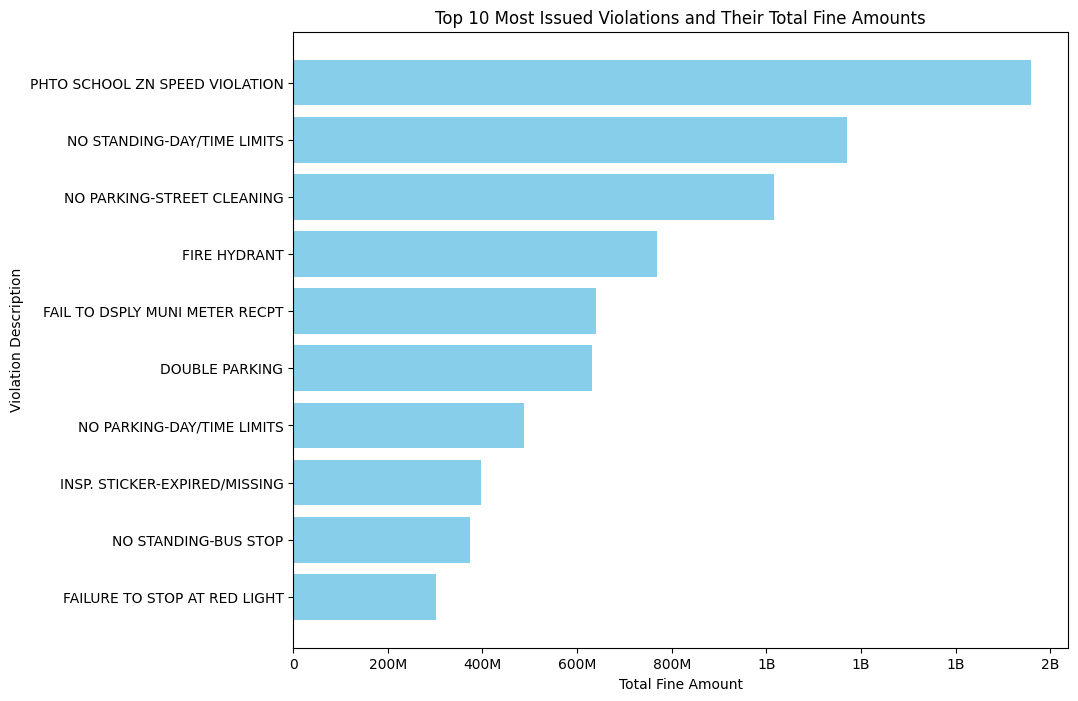

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extracting data for plotting
codes = violation_counts.select("violation_code").rdd.flatMap(lambda x: x).collect()
descriptions = violation_counts.select("violation_description").rdd.flatMap(lambda x: x).collect()
total_fines = violation_counts.select("total_fine").rdd.flatMap(lambda x: x).collect()

# Function to format large numbers
def format_large_numbers(x, pos):
    if x >= 1e9:
        return '{:,.0f}B'.format(x * 1e-9)
    elif x >= 1e6:
        return '{:,.0f}M'.format(x * 1e-6)
    elif x >= 1e3:
        return '{:,.0f}K'.format(x * 1e-3)
    else:
        return '{:,.0f}'.format(x)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(descriptions, total_fines, color='skyblue')
plt.xlabel('Total Fine Amount')
plt.ylabel('Violation Description')
plt.title('Top 10 Most Issued Violations and Their Total Fine Amounts')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest fine at the top
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_large_numbers))  # Apply the formatting function to x-axis
plt.show()

In [20]:
spark.stop()